# Entrenamiento y evaluacion



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_final=pd.read_csv('processed.csv')


In [4]:
X=df_final.drop(['Price_Category','Price'], axis=1).select_dtypes(include=[float, int])
y_price=df_final['Price']

In [5]:
X.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

Este código realiza la transformación logarítmica de la variable objetivo `y_price`, divide los datos en conjuntos de entrenamiento y prueba, y aplica escalado usando MinMaxScaler.Se reduce la dimensionalidad con PCA. La red neuronal definida tiene capas densas con activación 'swish' y una capa de salida. Se utiliza una función de pérdida personalizada, el error cuadrático logarítmico medio, y se entrena el modelo con early stopping. Las predicciones se transforman de nuevo a la escala original para calcular el error absoluto medio y se visualizan los resultados mediante gráficos de dispersión.


Epoch 1/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.5414 - val_loss: 0.1727
Epoch 2/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.4551 - val_loss: 0.2843
Epoch 3/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2082 - val_loss: 0.0193
Epoch 4/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0576 - val_loss: 0.0144
Epoch 5/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0481 - val_loss: 0.0325
Epoch 6/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0416 - val_loss: 0.0119
Epoch 7/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0412 - val_loss: 0.0165
Epoch 8/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0350 - val_loss: 0.0182
Epoch 9/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0307 - val_loss: 0.0090
Epoch 10/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0260 - val_loss: 0.0109
Epoch 11/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0257 - val_loss: 0.0085
Epoch 12/200
425/425 ━━━━━━━━━━━━━━━━━━━━

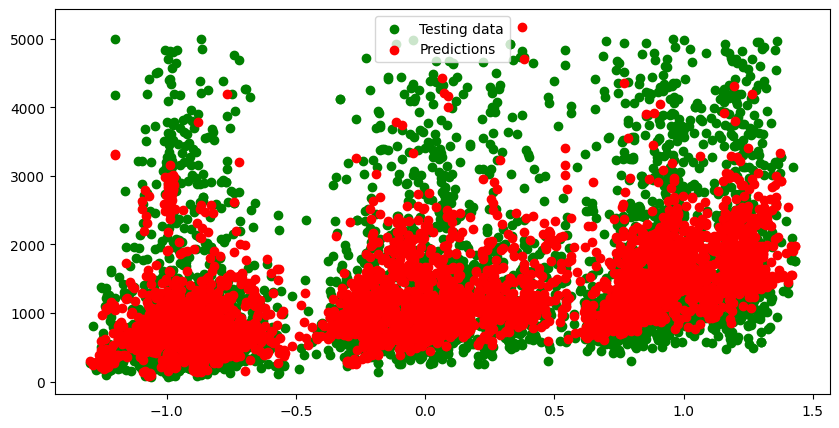

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
import tensorflow.keras.backend as K


# Transformación logarítmica de la variable objetivo
y_price_log_transformed = np.log1p(y_price)

# Dividir los datos en conjuntos de entrenamiento y prueba con y log-transformada
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_price_log_transformed, test_size=0.2, random_state=10)

# Aplicar MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar PCA 
pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

# Definir la arquitectura del modelo
model_log_transformed = Sequential([
    Dense(512, activation='swish', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='swish'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='swish'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1)  # Capa de salida para regresión
])

# Definir la función de error cuadrático logarítmico medio
def mean_squared_logarithmic_error(y_true, y_pred):
    y_pred = K.clip(y_pred, K.epsilon(), None)
    y_true = K.clip(y_true, K.epsilon(), None)
    first_log = K.log(y_pred + 1.)
    second_log = K.log(y_true + 1.)
    return K.mean(K.square(first_log - second_log), axis=-1)

# Compilar el modelo con la función de error cuadrático logarítmico medio
model_log_transformed.compile(optimizer='adam', loss=mean_squared_logarithmic_error)

# Configurar el early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entrenar el modelo con early stopping
history = model_log_transformed.fit(X_train_scaled, y_train_log, epochs=200, validation_split=0.2, callbacks=[early_stop], verbose=1)

# Realizar predicciones en los datos de prueba
y_pred_log_transformed = model_log_transformed.predict(X_test_scaled)

# Revertir la transformación logarítmica para obtener predicciones en la escala original
y_pred_original = np.expm1(y_pred_log_transformed)

# Revertir la transformación de y_test_log para obtener los valores verdaderos en la escala original
y_test_original = np.expm1(y_test_log)

# Calcular el error absoluto medio en la escala original
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f'Error absoluto medio estándar: {mae}')

# Graficar los resultados 
plt.figure(figsize=(10, 5))
plt.scatter(X_test_scaled[:, 0], y_test_original, color='green', label='Datos de prueba')
plt.scatter(X_test_scaled[:, 0], y_pred_original, color='red', label='Predicciones')
plt.legend()
plt.show()



In [91]:
import joblib 

joblib.dump(model_log_transformed, 'Trained_model_1.pkl')


Modelo guardado como knn_regressor_model.pkl


Este código carga datos preprocesados de un conjunto de datos CSV y realiza transformación logarítmica en la variable objetivo `y_price`. Luego, divide los datos en conjuntos de entrenamiento y prueba, escalando las características con `StandardScaler` y aplicando PCA para reducir la dimensionalidad manteniendo el 95% de la varianza explicada. Utiliza un modelo de regresión KNN con parámetros específicos como 11 vecinos ponderados por distancia de Manhattan. Se consiguieron estos parametros debido a un grdseatch.  

Mejores Parámetros: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Mejor Puntaje CV: 0.3816377476426788
Error Absoluto Medio (Mejor Modelo tras GridSearch): 501.24439344239215


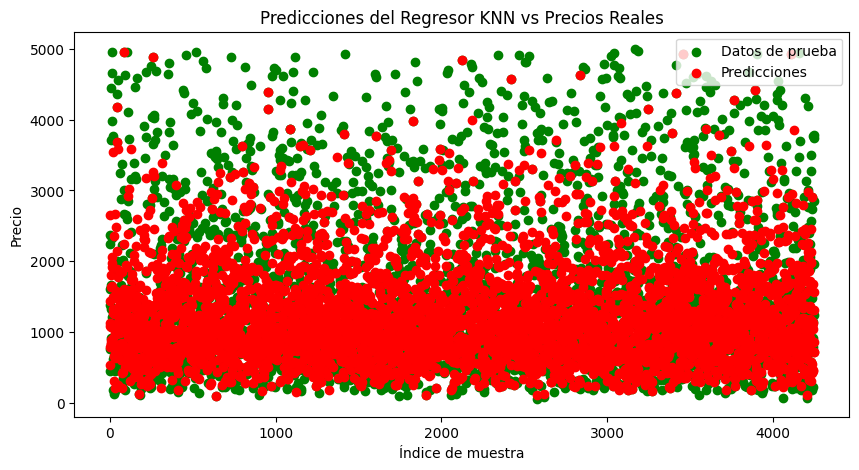

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error


# Transformación logarítmica de y
y_price_log = np.log1p(y_price)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_price_log, test_size=0.2, random_state=42)

# Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar PCA con retención del 95% de la varianza
pca = PCA(n_components=0.95)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

# Definir el parámetro grid para GridSearchCV
param_grid = {
    'n_neighbors': [5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Instanciar GridSearchCV con KNeighborsRegressor y el parámetro grid
grid_search = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5)

# Ajustar GridSearchCV a los datos de entrenamiento transformados por PCA
grid_search.fit(X_train_scaled_pca, y_train)

# Imprimir los mejores parámetros y el mejor puntaje
print("Mejores Parámetros:", grid_search.best_params_)
print("Mejor Puntaje CV:", -grid_search.best_score_)

# Predecir usando el mejor modelo encontrado por GridSearchCV en el conjunto de prueba
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test_scaled_pca)

# Transformar predicciones y valores reales de nuevo a la escala original
y_test_original = np.expm1(y_test)
y_pred_best_original = np.expm1(y_pred_best)

# Calcular y mostrar el Error Absoluto Medio en la escala original
mae_best = mean_absolute_error(y_test_original, y_pred_best_original)
print(f'Error Absoluto Medio (Mejor Modelo tras GridSearch): {mae_best}')

# Plotear las predicciones contra los valores reales
plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(y_test_original)), y_test_original, color='green', label='Datos de prueba')
plt.scatter(np.arange(len(y_pred_best_original)), y_pred_best_original, color='red', label='Predicciones')
plt.xlabel('Índice de muestra')
plt.ylabel('Precio')
plt.title('Predicciones del Regresor KNN vs Precios Reales')
plt.legend()
plt.show()


In [9]:
import joblib 

joblib.dump(best_knn, 'final_model.pkl')

['final_model.pkl']

Este modelo aplica una transformación logarítmica a la variable objetivo para estabilizar la varianza. Divide los datos en conjuntos de entrenamiento y prueba, y luego escala las características utilizando MinMaxScaler. Posteriormente, aplica PCA para reducir la dimensionalidad manteniendo el 95% de la varianza. El modelo es una red neuronal con varias capas densas y activación Swish, optimizada utilizando la pérdida de Huber. 

Epoch 1/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 4.7752 - val_loss: 0.2917
Epoch 2/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.9016 - val_loss: 0.1782
Epoch 3/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5951 - val_loss: 0.1880
Epoch 4/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4726 - val_loss: 0.1669
Epoch 5/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4061 - val_loss: 0.1660
Epoch 6/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.3674 - val_loss: 0.1581
Epoch 7/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3354 - val_loss: 0.1582
Epoch 8/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3128 - val_loss: 0.1562
Epoch 9/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3077 - val_loss: 0.1585
Epoch 10/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2921 - val_loss: 0.1507
Epoch 11/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2737 - val_loss: 0.1475
Epoch 12/200
425/425 ━━━━━━━━━━━━━━━━━━━

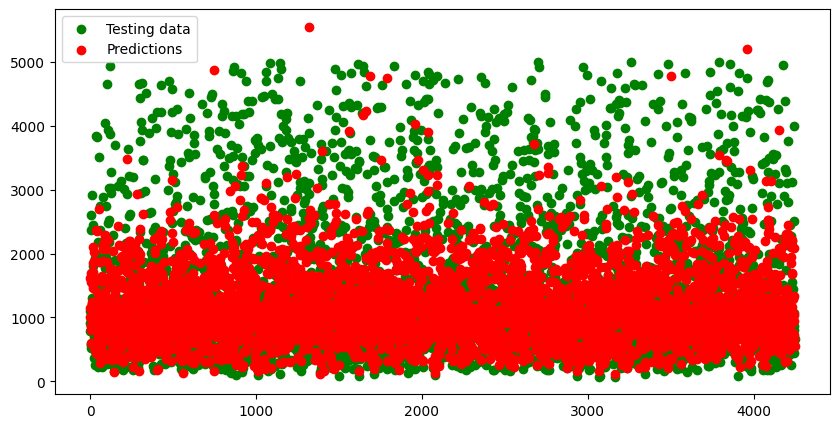

In [93]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


# Aplicar la transformación logarítmica a la variable objetivo
y_price_log = np.log1p(y_price)  

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_price_log, test_size=0.2, random_state=10)

# Aplicar MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar PCA
pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_train_pca.shape[1]

# Definir el modelo
model_hub = Sequential([
    Dense(512, activation='swish', input_shape=(X_train_pca.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='swish'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='swish'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='swish'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1)  # Capa de salida para regresión
])

# Compilar el modelo con Huber Loss
model_hub.compile(optimizer='adam', loss=tf.keras.losses.Huber())

# Configurar early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo con early stopping
history = model_hub.fit(X_train_pca, y_train, epochs=200, validation_split=0.2, callbacks=[early_stop], verbose=1)

# Hacer predicciones
y_pred_log = model_hub.predict(X_test_pca)

# Convertir las predicciones de nuevo a la escala original
y_pred_original = np.expm1(y_pred_log)  # expm1 es la inversa de log1p, es decir, exp(y) - 1

# Calcular el Error Absoluto Medio en la escala original
y_test_original = np.expm1(y_test)
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f'Standard Mean Absolute Error: {mae}')

# Graficar los resultados
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test_original)), y_test_original, color='green', label='Datos de prueba')
plt.scatter(range(len(y_pred_original)), y_pred_original, color='red', label='Predicciones')
plt.legend()
plt.show()




In [94]:
import joblib 

joblib.dump(model_hub, 'Trained_model_3.pkl')

['Trained_model_3.pkl']

El código carga y preprocesa los datos de entrada, aplica una transformación logarítmica a los valores objetivo para estabilizar la varianza y hacer la distribución más normal. Los datos se dividen en conjuntos de entrenamiento y prueba, se escalan utilizando MinMaxScaler y se reduce su dimensionalidad aplicando PCA para retener el 95% de la varianza. Se define y entrena un modelo de red neuronal con capas densas y activación Swish, empleando una pérdida de cuantiles para predecir un percentil específico (en este caso, el 56). Se usa early stopping para evitar el sobreajuste. Después del entrenamiento, las predicciones se invierten a la escala original y se evalúan usando el Error Absoluto Medio (MAE). Finalmente, se grafican las predicciones contra los valores reales de prueba.


Epoch 1/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 2.9388 - val_loss: 0.2890
Epoch 2/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.6760 - val_loss: 0.2777
Epoch 3/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.5232 - val_loss: 0.2429
Epoch 4/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4493 - val_loss: 0.2329
Epoch 5/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3929 - val_loss: 0.2276
Epoch 6/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3750 - val_loss: 0.2245
Epoch 7/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3562 - val_loss: 0.2253
Epoch 8/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3400 - val_loss: 0.2202
Epoch 9/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3257 - val_loss: 0.2197
Epoch 10/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3202 - val_loss: 0.2191
Epoch 11/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.3049 - val_loss: 0.2237
Epoch 12/200
425/425 ━━━━━━━━━━━━━━━━━━

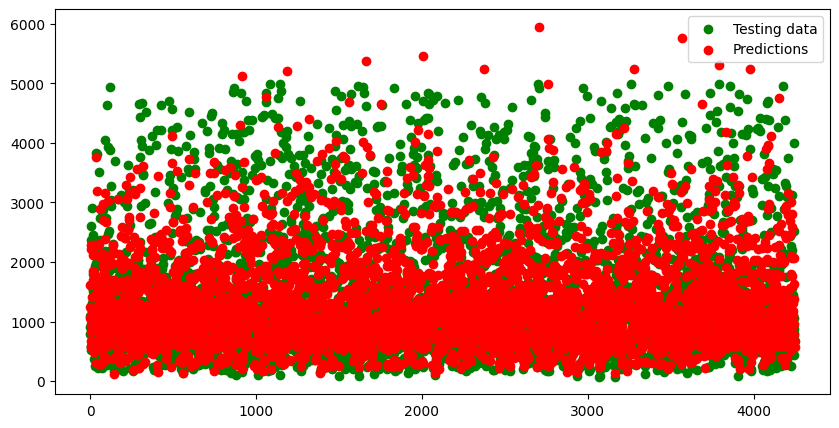

In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Función para calcular la pérdida de cuantiles
def quantile_loss(q, y_true, y_pred):
    err = y_true - y_pred
    return tf.reduce_mean(tf.maximum(q * err, (q - 1) * err), axis=-1)


# Definir el cuantil  a predecir 
quantile = 0.56

# Transformación logarítmica de y
y_price_log_transformed = np.log1p(y_price)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_price_log_transformed, test_size=0.2, random_state=10)

# Aplicar MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar PCA
pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Definir el modelo
model_q56 = Sequential([
    Dense(512, activation='swish', input_shape=(X_train_pca.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='swish'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='swish'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='swish'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1)  # Capa de salida para regresión
])

# Compilar el modelo
model_q56.compile(optimizer='adam', loss=lambda y_true, y_pred: quantile_loss(quantile, y_true, y_pred))

# Configurar early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo con early stopping
history = model_q56.fit(X_train_pca, y_train, epochs=200, validation_split=0.2, callbacks=[early_stop], verbose=1)

# Hacer predicciones
y_pred_transformed = model_q56.predict(X_test_pca)

# Invertir la transformación logarítmica en las predicciones
y_pred_original = np.expm1(y_pred_transformed)

# Invertir la transformación logarítmica en las etiquetas de prueba
y_test_original = np.expm1(y_test)

# Calcular el Error Absoluto Medio en la escala original
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f'Standard Mean Absolute Error with log transformation: {mae}')

# Graficar los resultados
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test_original)), y_test_original, color='green', label='Testing data')
plt.scatter(range(len(y_pred_original)), y_pred_original, color='red', label='Predictions')
plt.legend()
plt.show()


In [99]:
import joblib 

joblib.dump(model_q56, 'Trained_model_4.pkl')

['Trained_model_4.pkl']

Este código preprocesa los datos con una transformación logarítmica y los escala con MinMaxScaler. Luego aplica PCA para reducir la dimensionalidad al 90% de la varianza. Define y entrena un modelo de red neuronal con capas densas y activaciones Swish, utilizando una función de pérdida combinada de cuantiles y Huber para mejorar la precisión de las predicciones.


Epoch 1/350
425/425 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 7.7246 - val_loss: 0.5119
Epoch 2/350
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.5566 - val_loss: 0.4614
Epoch 3/350
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.1090 - val_loss: 0.4353
Epoch 4/350
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.9302 - val_loss: 0.4139
Epoch 5/350
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.8152 - val_loss: 0.3936
Epoch 6/350
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7495 - val_loss: 0.3828
Epoch 7/350
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7091 - val_loss: 0.3810
Epoch 8/350
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6494 - val_loss: 0.3817
Epoch 9/350
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6394 - val_loss: 0.3835
Epoch 10/350
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6125 - val_loss: 0.3807
Epoch 11/350
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5921 - val_loss: 0.3780
Epoch 12/350
425/425 ━━━━━━━━━━━━━━━━━━━━

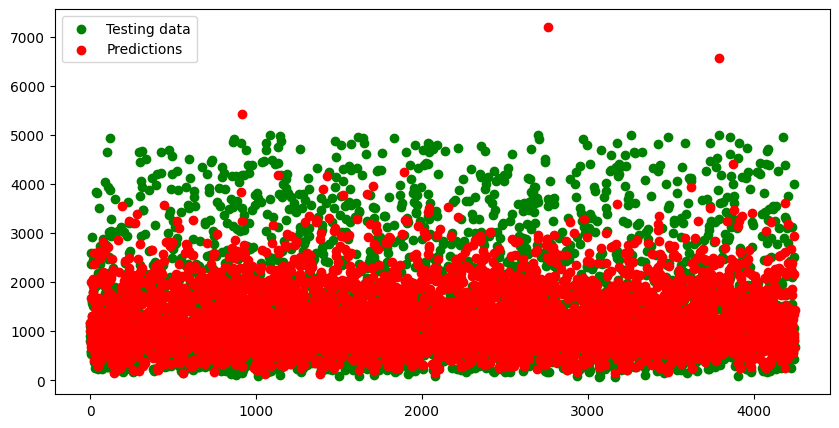

In [100]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Función para calcular la pérdida de cuantiles
def quantile_loss(q, y_true, y_pred):
    err = y_true - y_pred
    return tf.reduce_mean(tf.maximum(q * err, (q - 1) * err), axis=-1)

# Función para calcular la pérdida combinada (cuantil + Huber)
def combined_loss(q, y_true, y_pred):
    err = y_true - y_pred
    quantile_loss = tf.reduce_mean(tf.maximum(q * err, (q - 1) * err), axis=-1)
    huber_loss = tf.keras.losses.Huber(delta=1.0)(y_true, y_pred)
    return quantile_loss + huber_loss


# Definir el cuantil más alto a predecir (por ejemplo, 0.8 para el percentil 80)
quantile = 0.56

# Transformar las etiquetas utilizando np.log1p
y_price_log_transformed = np.log1p(y_price)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_price_log_transformed, test_size=0.2, random_state=10)

# Aplicar MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar PCA
pca = PCA(n_components=0.9)  # Mantener el 90% de la varianza
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Definir el modelo
model = Sequential([
    Dense(512, activation='swish', input_shape=(X_train_pca.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='swish'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='swish'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='swish'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1)  # Capa de salida para regresión
])

# Compilar el modelo con la función de pérdida combinada
model.compile(optimizer='adam', loss=lambda y_true, y_pred: combined_loss(quantile, y_true, y_pred))

# Configurar early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entrenar el modelo con early stopping
history = model.fit(X_train_pca, y_train, epochs=350, validation_split=0.2, callbacks=[early_stop], verbose=1)

# Hacer predicciones
y_pred_transformed = model.predict(X_test_pca)

# Invertir la transformación logarítmica en las predicciones
y_pred_original = np.expm1(y_pred_transformed)

# Invertir la transformación logarítmica en las etiquetas de prueba
y_test_original = np.expm1(y_test)

# Calcular el Error Absoluto Medio en la escala original
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f'Standard Mean Absolute Error with log transformation: {mae}')

# Graficar los resultados
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test_original)), y_test_original, color='green', label='Testing data')
plt.scatter(range(len(y_pred_original)), y_pred_original, color='red', label='Predictions')
plt.legend()
plt.show()


In [101]:
import joblib 

joblib.dump(model, 'Trained_model_5.pkl')

['Trained_model_5.pkl']

In [8]:
train_data = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X_train.shape[1])])
train_data['y_price'] = np.expm1(y_train)  # Convertir las etiquetas a la escala original
train_data.to_csv('train.csv', index=False)

test_data = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X_test.shape[1])])
test_data['y_price'] = np.expm1(y_test)  # Convertir las etiquetas a la escala original
test_data.to_csv('test.csv', index=False)